C:\Users\sures\AppData\Local\Temp\ipykernel_4672\2792345871.py:73: RuntimeWarning: invalid value encountered in divide
  nbr_pre = (nir_pre.astype(float) - swir_pre_resampled.astype(float)) / (nir_pre + swir_pre_resampled)
C:\Users\sures\AppData\Local\Temp\ipykernel_4672\2792345871.py:74: RuntimeWarning: invalid value encountered in divide
  nbr_post = (nir_post.astype(float) - swir_post_resampled.astype(float)) / (nir_post + swir_post_resampled)


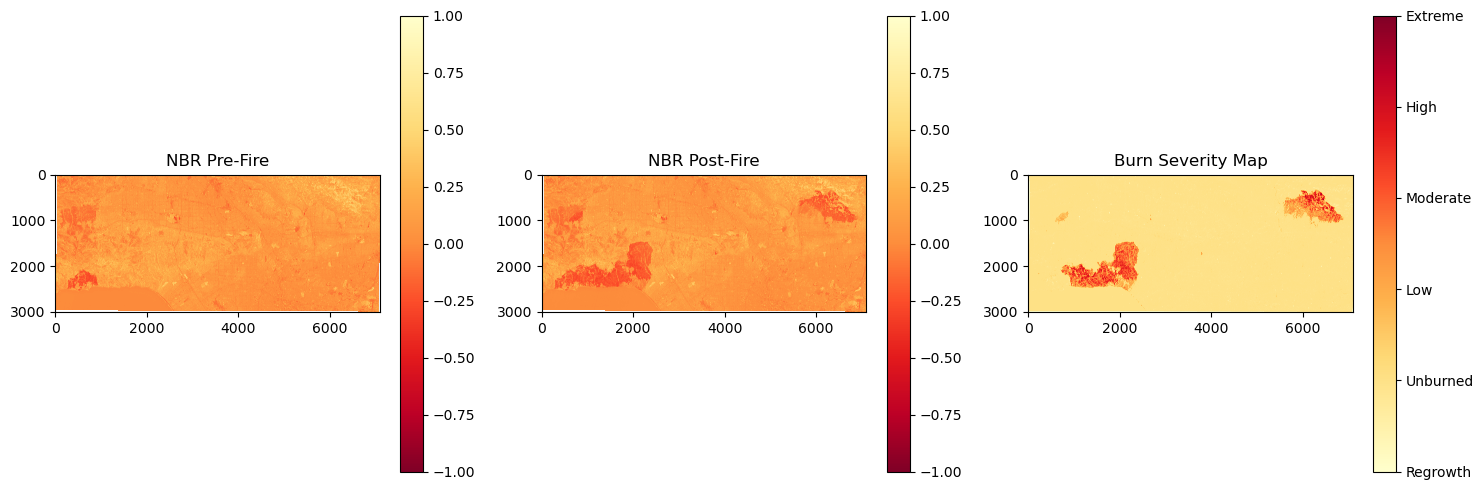

In [3]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import mapping
import zipfile
import os
import tempfile

# Function to extract AOI from ZIP file
def extract_aoi(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    
    for root, _, files in os.walk(extract_to):
        for file in files:
            if file.endswith(".shp"):
                return os.path.join(root, file)
    return None

# Function to read and mask raster
def read_and_mask_raster(image_file, aoi_geom):
    with rasterio.open(image_file) as src:
        masked_img, _ = mask(src, aoi_geom, crop=True)
        return masked_img[0], src.meta

# Function to resample raster
def resample_raster(source_array, source_meta, target_shape, target_meta):
    dst_array = np.empty(target_shape, dtype=np.float32)
    reproject(
        source=source_array,
        destination=dst_array,
        src_transform=source_meta['transform'],
        src_crs=source_meta['crs'],
        dst_transform=target_meta['transform'],
        dst_crs=target_meta['crs'],
        resampling=Resampling.bilinear
    )
    return dst_array

# Paths for input files
nir_pre_path = "Downloads/pre/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/GRANULE/L2A_T11SLT_A040665_20241218T183708/IMG_DATA/R10m/T11SLT_20241218T183709_B08_10m.jp2"
swir_pre_path = "Downloads/pre/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/S2B_MSIL2A_20241218T183709_N0511_R027_T11SLT_20241218T222347.SAFE/GRANULE/L2A_T11SLT_A040665_20241218T183708/IMG_DATA/R20m/T11SLT_20241218T183709_B12_20m.jp2"
nir_post_path = "Downloads/post/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/GRANULE/L2A_T11SLT_A049931_20250112T183727/IMG_DATA/R10m/T11SLT_20250112T183731_B08_10m.jp2"
swir_post_path = "Downloads/post/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/S2A_MSIL2A_20250112T183731_N0511_R027_T11SLT_20250112T222951.SAFE/GRANULE/L2A_T11SLT_A049931_20250112T183727/IMG_DATA/R20m/T11SLT_20250112T183731_B12_20m.jp2"
aoi_zip_path = "C:/Users/sures/OneDrive/Desktop/abc.zip"

# Process AOI
with tempfile.TemporaryDirectory() as tmpdir:
    aoi_path = extract_aoi(aoi_zip_path, tmpdir)
    if not aoi_path:
        raise ValueError("No shapefile (.shp) found in the uploaded ZIP. Check your AOI file.")
    
    aoi = gpd.read_file(aoi_path)
    if aoi.empty:
        raise ValueError("The uploaded shapefile is empty or invalid.")
    
    aoi_geom = [mapping(aoi.geometry.iloc[0])]

    # Read and mask rasters
    nir_pre, nir_meta = read_and_mask_raster(nir_pre_path, aoi_geom)
    swir_pre, swir_meta = read_and_mask_raster(swir_pre_path, aoi_geom)
    nir_post, _ = read_and_mask_raster(nir_post_path, aoi_geom)
    swir_post, _ = read_and_mask_raster(swir_post_path, aoi_geom)

    # Resample SWIR bands to match NIR resolution
    swir_pre_resampled = resample_raster(swir_pre, swir_meta, nir_pre.shape, nir_meta)
    swir_post_resampled = resample_raster(swir_post, swir_meta, nir_post.shape, nir_meta)

    # Compute NBR and dNBR
    nbr_pre = (nir_pre.astype(float) - swir_pre_resampled.astype(float)) / (nir_pre + swir_pre_resampled)
    nbr_post = (nir_post.astype(float) - swir_post_resampled.astype(float)) / (nir_post + swir_post_resampled)
    dnbr = nbr_pre - nbr_post

    # Classify Burn Severity
    burn_severity = np.zeros_like(dnbr)
    burn_severity[dnbr < -0.1] = 1  # Regrowth
    burn_severity[(dnbr >= -0.1) & (dnbr < 0.1)] = 2  # Unburned
    burn_severity[(dnbr >= 0.1) & (dnbr < 0.27)] = 3  # Low Severity
    burn_severity[(dnbr >= 0.27) & (dnbr < 0.44)] = 4  # Moderate Severity
    burn_severity[(dnbr >= 0.44) & (dnbr < 0.66)] = 5  # High Severity
    burn_severity[dnbr >= 0.66] = 6  # Extreme Severity

    # Plot Results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    im1 = axes[0].imshow(nbr_pre, cmap='YlOrRd_r', vmin=-1, vmax=1)
    axes[0].set_title("NBR Pre-Fire")
    plt.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(nbr_post, cmap='YlOrRd_r', vmin=-1, vmax=1)
    axes[1].set_title("NBR Post-Fire")
    plt.colorbar(im2, ax=axes[1])

    im3 = axes[2].imshow(burn_severity, cmap='YlOrRd', vmin=1, vmax=6)
    axes[2].set_title("Burn Severity Map")
    cbar = fig.colorbar(im3, ax=axes[2], ticks=range(1, 7))
    cbar.ax.set_yticklabels(["Regrowth", "Unburned", "Low", "Moderate", "High", "Extreme"])

    plt.tight_layout()
    plt.show()

In [4]:
from rasterio.transform import from_origin

# Define output file path
output_raster_path = "burn_severity.tif"

# Update metadata
burn_meta = nir_meta.copy()
burn_meta.update({
    "driver": "GTiff",
    "dtype": rasterio.uint8,
    "count": 1,
    "compress": "lzw"
})

# Save raster
with rasterio.open(output_raster_path, "w", **burn_meta) as dst:
    dst.write(burn_severity.astype(rasterio.uint8), 1)


In [5]:
import rasterio

with rasterio.open("burn_severity.tif") as src:
    print("Bounds:", src.bounds)
    print("CRS:", src.crs)


Bounds: BoundingBox(left=300000.0, bottom=3690240.0, right=409800.0, top=3800040.0)
CRS: EPSG:32611


In [9]:
import geopandas as gpd

aoi = gpd.read_file("C:/Users/sures/OneDrive/Desktop/aoi/boundary 1.shp")
print("AOI CRS:", aoi.crs)
print("AOI Bounds:", aoi.total_bounds)


AOI CRS: EPSG:32611
AOI Bounds: [ 337276.198  3762176.8112  408277.995  3792273.0954]


In [10]:
import rasterio
import rasterio.mask
import geopandas as gpd
import fiona

# Load AOI shapefile
aoi = gpd.read_file("C:/Users/sures/OneDrive/Desktop/aoi/boundary 1.shp")

# Open raster
with rasterio.open("burn_severity.tif") as src:
    # Mask the raster using AOI
    out_image, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

# Save clipped raster
with rasterio.open("burn_severity_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Clipped raster saved as burn_severity_clipped.tif")


✅ Clipped raster saved as burn_severity_clipped.tif


In [13]:
import rasterio
import rasterio.mask
import geopandas as gpd

# Load AOI
aoi = gpd.read_file("C:/Users/sures/OneDrive/Desktop/aoi/boundary 1.shp")
aoi = aoi.to_crs(epsg=32611)  # Ensure correct CRS
aoi = aoi.dissolve()  # Merge all features
aoi.geometry = aoi.geometry.buffer(10)  # Expand slightly

# Open Raster
with rasterio.open("burn_severity") as src:
    out_image, out_transform = rasterio.mask.mask(src, aoi.geometry, crop=True, all_touched=True)
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save Clipped Raster
with rasterio.open("burn_severity_clipped2.tif", "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Clipped raster saved as burn_severity_clipped2.tif")


✅ Clipped raster saved as burn_severity_clipped2.tif


In [16]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Open original raster
with rasterio.open("burn_severity.tif") as src:
    dst_crs = "EPSG:32611"  # Match AOI CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Update metadata
    kwargs = src.meta.copy()
    kwargs.update({"crs": dst_crs, "transform": transform, "width": width, "height": height})

    # Save reprojected raster
    with rasterio.open("reprojected_raster.tif", "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )


In [18]:
import geopandas as gpd
from rasterio.mask import mask

# Load shapefile (AOI)
aoi = gpd.read_file("C:/Users/sures/OneDrive/Desktop/aoi/boundary 1.shp")

# Open reprojected raster
with rasterio.open("reprojected_raster.tif") as src:
    out_image, out_transform = mask(src, aoi.geometry, crop=True)

    # Update metadata
    out_meta = src.meta.copy()
    out_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save final aligned raster
with rasterio.open("aligned_raster.tif", "w", **out_meta) as dest:
    dest.write(out_image)


In [20]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import box
import fiona

# Open the raster
raster_path = "burn_severity.tif"
output_path = "clipped_raster2.tif"

with rasterio.open(raster_path) as src:
    # Define AOI Bounds
    minx, miny, maxx, maxy = [337276.198, 3762176.8112, 408277.995, 3792273.0954]
    aoi_geom = [box(minx, miny, maxx, maxy)]  # Create a polygon from bounds

    # Clip raster
    out_image, out_transform = mask(src, aoi_geom, crop=True)

    # Update metadata
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Save the clipped raster
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(out_image)

print("✅ Raster clipped exactly to AOI bounds!")


✅ Raster clipped exactly to AOI bounds!


In [21]:
# Save the figure
plt.savefig("burn_severity_map5.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()


<Figure size 640x480 with 0 Axes>